# Milestone 3

In [1]:
# Imports
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler

In [2]:
# Display options
pd.set_option('display.max_rows', 100)

In [3]:
# Read CSV data
voter_blocks_all = pd.read_csv('../data/MA_l2_2022stats_2020block/MA_l2_2022stats_2020block.csv', low_memory=False).set_index('geoid20')
display(voter_blocks_all.shape)

# Read shapefile
block_groups_all = gpd.read_file('../data/ma_pl2020_bg/ma_pl2020_bg.shp')
display(block_groups_all.shape)


(107292, 395)

(5116, 346)

## Data Cleaning and Processing

### Define and Rename Columns

We define the columns of interest and rename the columns for language and gender for easier interpretation.

In [4]:
# Group demographic columns together
registered = ['total_reg']
age = ['age_18_19', 'age_20_24', 'age_25_29','age_30_34','age_35_44', 'age_45_54', 'age_55_64', 'age_65_74','age_75_84', 'age_85over']
old_gender = [ 'voters_gender_m', 'voters_gender_f', 'voters_gender_unknown'] 
gender = [ 'gender_m', 'gender_f', 'gender_unknown'] 
party = ['party_npp', 'party_dem', 'party_rep','party_lib', 'party_grn', 'party_con', 'party_ain', 'party_scl','party_oth', 'party_unk']
ethnicity1 = ['eth1_eur', 'eth1_hisp', 'eth1_aa',
                'eth1_esa', 'eth1_oth', 'eth1_unk']
ethnicity2 = ['eth2_euro', 'eth2_64',
                'eth2_93', 'eth2_10', 'eth2_30', 'eth2_23', 'eth2_66', 'eth2_34',
                'eth2_21', 'eth2_35', 'eth2_14', 'eth2_12', 'eth2_55', 'eth2_13',
                'eth2_32', 'eth2_61', 'eth2_85', 'eth2_29', 'eth2_33', 'eth2_38',
                'eth2_15', 'eth2_57', 'eth2_19', 'eth2_26', 'eth2_59', 'eth2_unk']
old_languages = ['languages_description_english', 'languages_description_spanish',
                'languages_description_portuguese',
                'languages_description_chinese', 'languages_description_italian',
                'languages_description_vietnamese', 'languages_description_other',
                'languages_description_unknown']
languages = ['lang_english', 'lang_spanish',
                'lang_portuguese',
                'lang_chinese', 'lang_italian',
                'lang_vietnamese', 'lang_other',
                'lang_unknown']
income = ['commercialdata_estimatedhhincomeamount_avg']

# Group variables related to the 2020 presidential election
presidential_2020 = ['g20201103_voted_all', 'g20201103_reg_all', 'g20201103_pct_voted_all',
                    'g20201103_voted_gender_m', 'g20201103_reg_gender_m',
                    'g20201103_pct_voted_gender_m', 'g20201103_voted_gender_f',
                    'g20201103_reg_gender_f', 'g20201103_pct_voted_gender_f',
                    'g20201103_voted_gender_unk', 'g20201103_reg_gender_unk',
                    'g20201103_pct_voted_gender_unk', 'g20201103_voted_eur',
                    'g20201103_reg_eur', 'g20201103_pct_voted_eur', 'g20201103_voted_hisp',
                    'g20201103_reg_hisp', 'g20201103_pct_voted_hisp', 'g20201103_voted_aa',
                    'g20201103_reg_aa', 'g20201103_pct_voted_aa', 'g20201103_voted_esa',
                    'g20201103_reg_esa', 'g20201103_pct_voted_esa', 'g20201103_voted_oth',
                    'g20201103_reg_oth', 'g20201103_pct_voted_oth', 'g20201103_voted_unk',
                    'g20201103_reg_unk', 'g20201103_pct_voted_unk']

# Define columns with counts for voters registered and voted in 2020 presidential election (excludes percentages)
presidential_counts = [col for col in presidential_2020 if not '_pct_' in col]

In [5]:
# Rename columns for easier intepretation
col_labels = {k:v for k, v in zip(old_gender, gender)}
col_labels.update({k:v for k,v in zip(old_languages, languages)})
voter_blocks_all = voter_blocks_all.rename(col_labels, axis=1)

### Missing Data Handling

#### 'NO BLOCK ASSIGNMENT' entries

We are choosing to ignore and drop these values because of inappropriate assumptions that need to be made if trying to disaggregate these entries.

Similarly, using counties as our unit of observation is difficult due to there only being 14 counties.

It seems as though counties with lower population have higher proportion of unassigned voters.

We will also explore the excluded data to determine which population groups we might be disproportionately excluding.

In [6]:
# Drop 'NO BLOCK ASSIGNMENT' entries
voter_blocks = voter_blocks_all[~voter_blocks_all.index.str.contains('NO BLOCK ASSIGNMENT')].copy()

#### Null voter turnout percentages

Some Census Block Groups have missing percentage voter turnout for the 2020 presidential election due to not having any voters registered for that election.

We choose to drop Census Block Groups that have zero voters registered for the 2020 presidential election (and total voters registered), as they are useless for our analysis.

In [7]:
# Drop Census Blocks with zero voters registered during the 2020 presidential election or ever
voter_blocks = voter_blocks[voter_blocks['g20201103_reg_all'] > 0]
voter_blocks = voter_blocks[voter_blocks['total_reg'] > 0]

###  Aggregation to Block Groups

Some Census Blocks are incredibly small, causing proportions to change wildly for small changes in counts.

We will aggregate the data to Census Block Groups to minimize the effects of incredibly small samples in Census Blocks.

#### Impute income data 

We are aggregating our data to the Census Block Group level and taking the mean of the mean household income at the Census Block level weighted by the number of total voters in each Census Block.

Even after imputation, there are 4 Census Block Groups still missing income data, with 14 voters in those Census Block Groups (0.00031% of the total).

We chose to drop these observations

In [8]:
# Weighted mean function based on total registered voters
wm = lambda x: (
    np.average(x.dropna(), weights=voter_blocks.loc[x.dropna().index, 'total_reg'])
    if voter_blocks.loc[x.dropna().index, 'total_reg'].sum() > 0
    else np.nan
)

# Define aggregation method for columns
agg_funcs = {col: 'sum' for col in [*registered, *age, *gender, *party, *ethnicity1, *languages, *presidential_counts]}
agg_funcs.update({'commercialdata_estimatedhhincomeamount_avg': wm})

# Define block group ID
voter_blocks['block_group_id'] = voter_blocks.index.str[:12]
block_groups = voter_blocks.groupby('block_group_id').agg(agg_funcs)

# Rename the income column
block_groups = block_groups.rename({'commercialdata_estimatedhhincomeamount_avg':'mean_hh_income'}, axis=1)

In [9]:
block_groups[block_groups['mean_hh_income'].isna()]

,total_reg,age_18_19,age_20_24,age_25_29,age_30_34,age_35_44,age_45_54,age_55_64,age_65_74,age_75_84,...,g20201103_reg_hisp,g20201103_voted_aa,g20201103_reg_aa,g20201103_voted_esa,g20201103_reg_esa,g20201103_voted_oth,g20201103_reg_oth,g20201103_voted_unk,g20201103_reg_unk,mean_hh_income
block_group_id,,,,,,,,,,,,,,,,,,,,,
250173840031,9,0,0,1,1,3,1,2,1,0,...,2,0,0,0,0,0,1,0,1,NaN
250250612021,2,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,NaN
250259809001,2,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,NaN
250259815021,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,NaN


In [10]:
print(f'After imputation, there are a total of {len(block_groups[block_groups['mean_hh_income'].isna()].index)} Census Block Groups still missing income data, with {block_groups[block_groups['mean_hh_income'].isna()]['total_reg'].sum()} voters in those Census Block Groups ({block_groups[block_groups['mean_hh_income'].isna()]['total_reg'].sum()/block_groups['total_reg'].sum():.5%} of the total).')

After imputation, there are a total of 4 Census Block Groups still missing income data, with 14 voters in those Census Block Groups (0.00031% of the total).


In [11]:
# Choose to drop NaN values for income due to low number of voters in these blocks.
block_groups = block_groups.dropna(subset='mean_hh_income')

#### Only keep columns of interest

We drop all other columns that are not of interest. We discovered that voter counts with 'unknown' party are extremely few (at most 1 voter per Census Block) and that after dropping Census Blocks with zero voters registered for the 2020 presidential election, all values for this column are 0. So, we can drop this column without losing any information.

In [12]:
# Only keep columns of interest
party = ['party_npp', 'party_dem', 'party_rep','party_lib', 'party_grn', 'party_con', 'party_ain', 'party_scl','party_oth']
predictors = [*registered, *age, *gender, *party, *ethnicity1, *languages, 'mean_hh_income']
# Other potential response variables could be g20201103_voted_all or those who voted and are a part of a certain demographic group
response = 'g20201103_pct_voted_all'
block_groups[response] = block_groups['g20201103_voted_all'] / block_groups['g20201103_reg_all']

### Take Proportions

Instead of using demographic counts as our predictors, we are choosing to use demographic proportions (i.e. the percentage of people that identify as _ in each Census Block Group).

We will use the number of voters registered in each Census Block Group as weights in our analysis to account for the fact that Census Block Groups with low voter registration counts can have wildly different demographic proportions.

In [13]:
def plot_vars(df, stat):

    fig, axes = plt.subplots(nrows=3,ncols=2,figsize = (15,15))

    axes = axes.ravel()

    sns.boxplot(df.melt(value_vars=age,var_name='Age Group',value_name=stat),x='Age Group', y=stat, ax=axes[0])
    axes[0].set_xticks(ticks=np.arange(len(age)),labels=age,rotation=45, ha='right')

    sns.boxplot(df.melt(value_vars=gender,var_name='Gender',value_name=stat), x='Gender', y=stat, ax=axes[1])

    sns.boxplot(df.melt(value_vars=party,var_name='Party',value_name=stat), x='Party', y=stat, ax=axes[2])
    axes[2].set_xticks(ticks=np.arange(len(party)),labels=party,rotation=45, ha='right')

    sns.boxplot(df.melt(value_vars=ethnicity1,var_name='Ethnicity',value_name=stat), x='Ethnicity', y=stat, ax=axes[3])

    sns.boxplot(df.melt(value_vars=languages,var_name='Language',value_name=stat), x='Language', y=stat, ax=axes[4])
    axes[4].set_xticks(ticks=np.arange(len(languages)),labels=languages, rotation=45, ha='right')

    plt.tight_layout()

    return axes

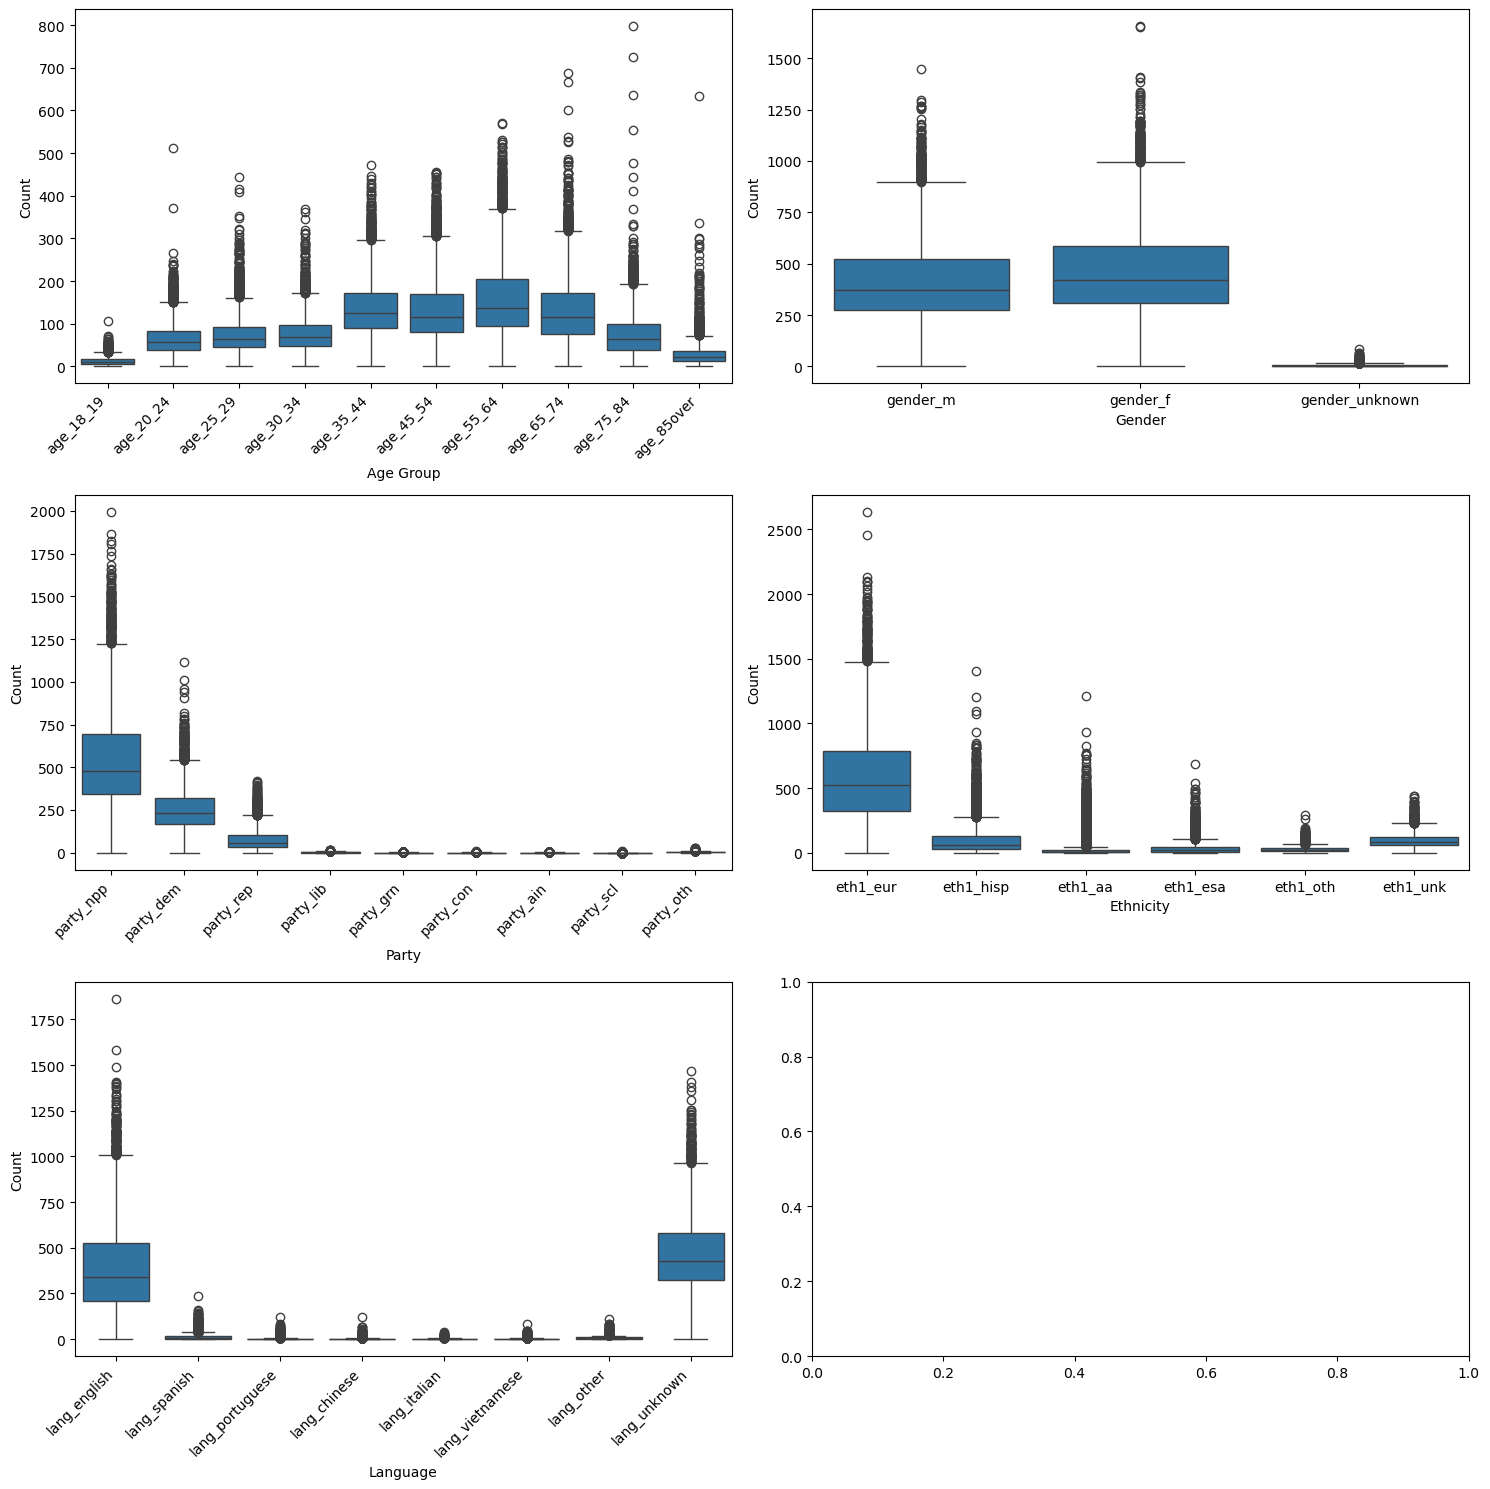

In [14]:
# Before transformation
axes = plot_vars(block_groups, 'Count')

In [15]:
# Take proportions
for cat in [*age, *gender, *party, *ethnicity1, *languages]:
    block_groups[cat] = block_groups[cat] / block_groups['total_reg']

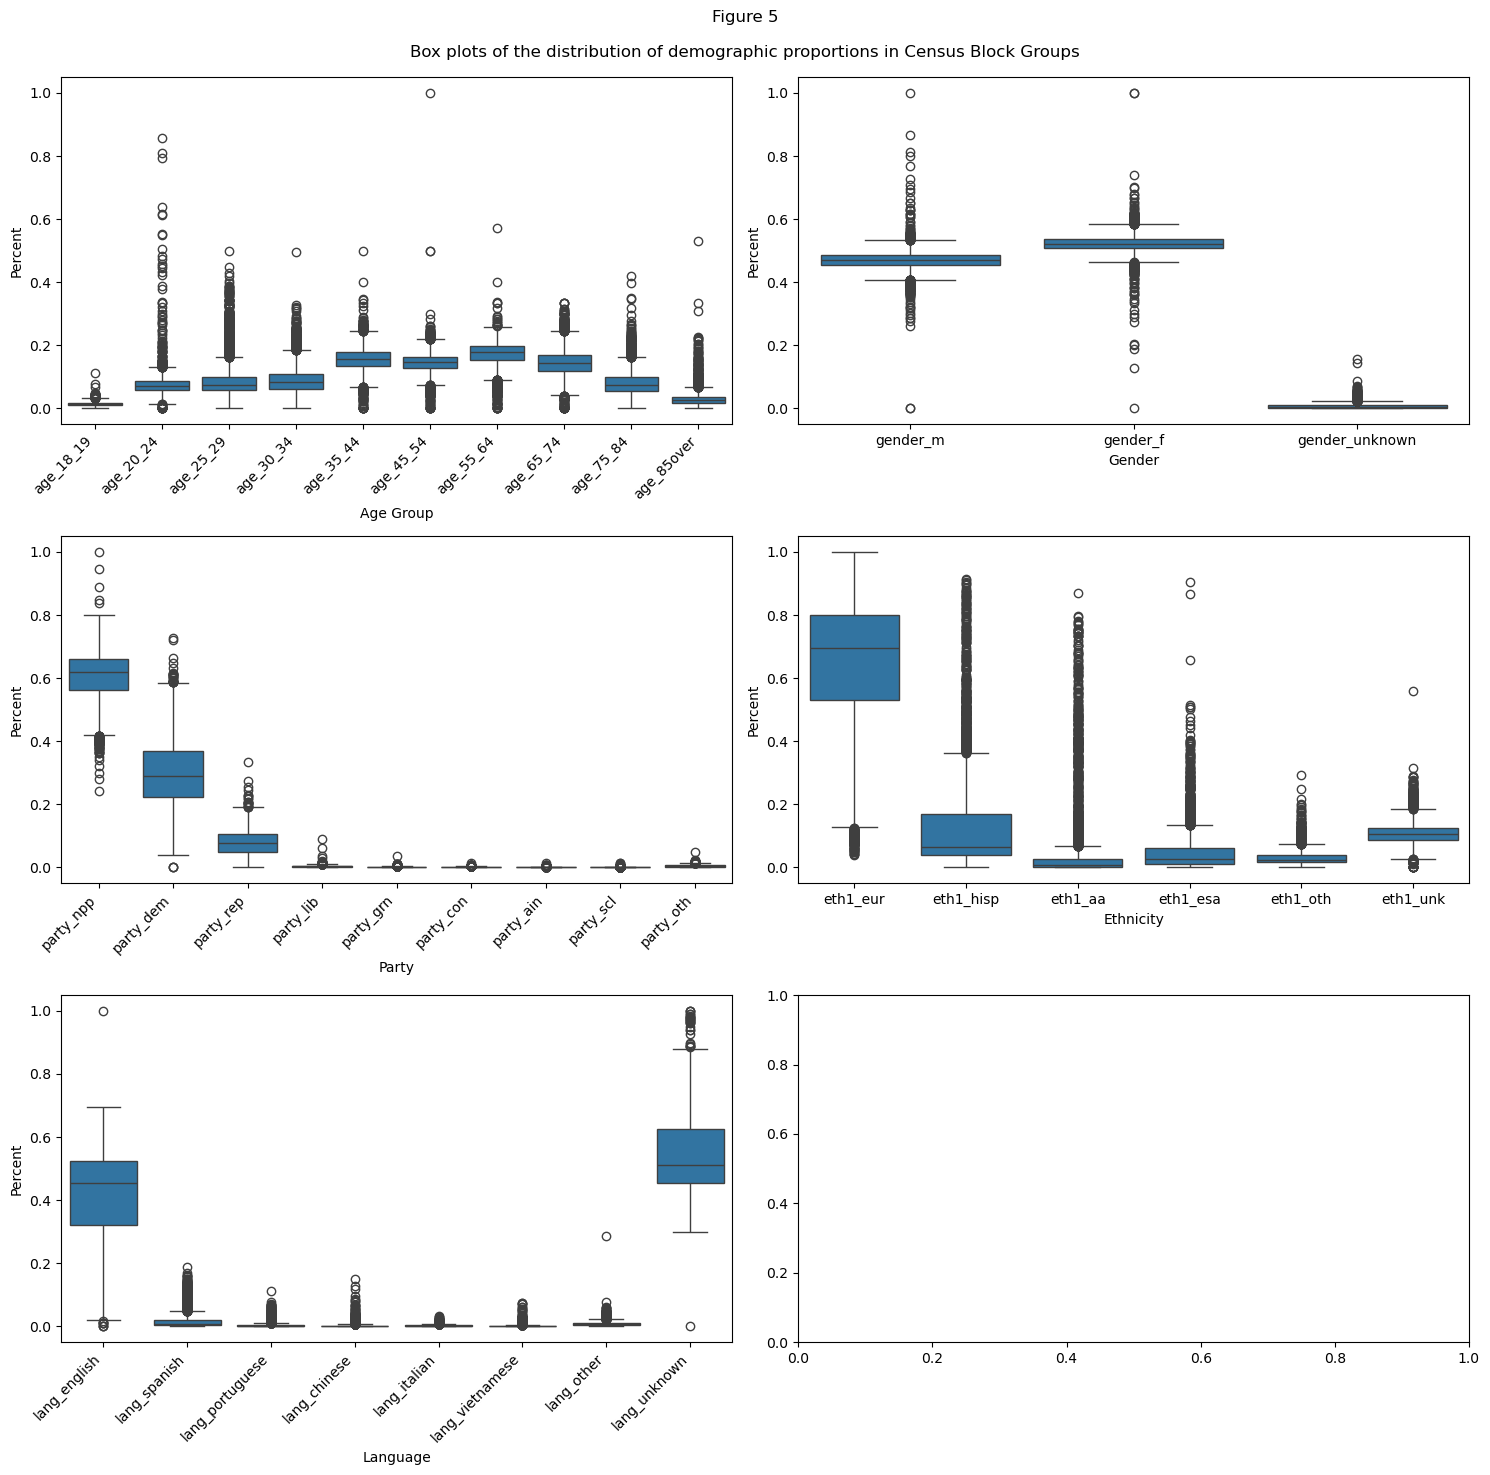

In [16]:
# After transformation
axes = plot_vars(block_groups, 'Percent')
plt.suptitle('Figure 5\n\nBox plots of the distribution of demographic proportions in Census Block Groups\n')
plt.tight_layout()

### Join to Shapefile

Finally, we join the data to Census Block Groups shapefile for visualization purposes and to potentially use the geographic locations of Census Blocks in our analysis.

In [17]:
final_gdf = block_groups_all.merge(block_groups, left_on='GEOID20', right_on='block_group_id').set_index('GEOID20').rename({'P0010001':'total_pop','P0030001':'18+_pop'}, axis=1)

# Total Non-Hispanic White population
final_gdf['total_nh_white'] = final_gdf['P0020005'] / final_gdf['total_pop']

# 18+ Non-Hispanic White population
final_gdf['18+_nh_white'] = final_gdf['P0040005'] / final_gdf['18+_pop']

# Total Hispanic population
final_gdf['total_hisp'] = final_gdf['P0020002'] / final_gdf['total_pop']

# 18+ Hispanic population
final_gdf['18+_hisp'] = final_gdf['P0040002'] / final_gdf['18+_pop']

# Total Any Part Black population (sum of Black alone and combinations)
final_gdf['total_ap_black'] = (
    final_gdf['P0020006'] +  # Black alone
    final_gdf['P0020013'] +  # White; Black or African American
    final_gdf['P0020018'] +  # Black or African American; American Indian and Alaska Native
    final_gdf['P0020019'] +  # Black or African American; Asian
    final_gdf['P0020020'] +  # Black or African American; Native Hawaiian and Other Pacific Islander
    final_gdf['P0020021']    # Black or African American; Some Other Race
)  / final_gdf['total_pop']

# 18+ Any Part Black population (sum of Black alone and combinations, 18+)
final_gdf['18+_ap_black'] = (
    final_gdf['P0040006'] +  # Black alone 18+
    final_gdf['P0040013'] +  # White; Black or African American 18+
    final_gdf['P0040018'] +  # Black or African American; American Indian and Alaska Native 18+
    final_gdf['P0040019'] +  # Black or African American; Asian 18+
    final_gdf['P0040020'] +  # Black or African American; Native Hawaiian and Other Pacific Islander 18+
    final_gdf['P0040021']    # Black or African American; Some Other Race 18+
) / final_gdf['18+_pop']

# Total Any Part Asian population (sum of Asian alone and combinations)
final_gdf['total_ap_asian'] = (
    final_gdf['P0020008'] +  # Asian alone
    final_gdf['P0020015'] +  # White; Asian
    final_gdf['P0020019'] +  # Black or African American; Asian
    final_gdf['P0020022'] +  # American Indian and Alaska Native; Asian
    final_gdf['P0020025'] +  # Asian; Native Hawaiian and Other Pacific Islander
    final_gdf['P0020026']    # Asian; Some Other Race
) / final_gdf['total_pop']

# 18+ Any Part Asian population (sum of Asian alone and combinations, 18+)
final_gdf['18+_ap_asian'] = (
    final_gdf['P0040008'] +  # Asian alone 18+
    final_gdf['P0040015'] +  # White; Asian 18+
    final_gdf['P0040019'] +  # Black or African American; Asian 18+
    final_gdf['P0040022'] +  # American Indian and Alaska Native; Asian 18+
    final_gdf['P0040025'] +  # Asian; Native Hawaiian and Other Pacific Islander 18+
    final_gdf['P0040026']    # Asian; Some Other Race 18+
) / final_gdf['18+_pop']

final_gdf['tract_id'] = final_gdf.index.str[:10]
final_gdf['county_id'] = final_gdf.index.str[:5]

In [18]:
# keep_cols = predictors + [response] + presidential_counts + ['tract_id','county_id','ALAND20', 'AWATER20', 'geometry', 'total_pop', '18+_pop', 'total_nh_white', '18+_nh_white', 'total_hisp', '18+_hisp', 'total_ap_black', '18+_ap_black', 'total_ap_asian', '18+_ap_asian']
# keep_cols = predictors + [response] + presidential_counts + ['tract_id','county_id','ALAND20', 'AWATER20', 'geometry']
keep_cols = predictors + [response] + ['g20201103_voted_all','g20201103_reg_all','tract_id','county_id','ALAND20', 'AWATER20', 'geometry']
final_gdf = final_gdf[keep_cols]

### Final Data

After all processing has been done:
The number of voters registered has dropped from **4,606,321** to **4,532,271**.
**1.61%** of total registered voters were dropped.

In [19]:
print('\t\t\tBefore processing\tAfter processing')
print(f'Voters Registered:\t{voter_blocks_all['total_reg'].sum():,d}\t\t{final_gdf['total_reg'].sum():,d}')
print(f'{(voter_blocks_all['total_reg'].sum() - final_gdf['total_reg'].sum()) / voter_blocks_all['total_reg'].sum():.2%} of total registered voters were dropped.')

			Before processing	After processing
Voters Registered:	4,606,321		4,532,271
1.61% of total registered voters were dropped.


In [20]:
# Optionally export the data for CS1710
final_gdf.to_file('../data/block_groups.geojson', driver='GeoJSON')

## Exploratory Data Analysis

### Summary of the Data

In [21]:
# Use final_gdf for further analysis
# Display shape, one of the columns is 'geometry'
print(f'The final shape of the data is: {final_gdf.shape}')
# Display total registered voters
print(f'The total number of voters registered is {final_gdf['total_reg'].sum():,d}')
print(f'The total number of voters registered for the 2020 presidential election is {final_gdf['g20201103_reg_all'].sum():,d}')
print(f'The total number of voters who voted in the 2020 presidential election is {final_gdf['g20201103_voted_all'].sum():,d}')

The final shape of the data is: (5078, 46)
The total number of voters registered is 4,532,271
The total number of voters registered for the 2020 presidential election is 4,122,730
The total number of voters who voted in the 2020 presidential election is 3,324,195


In [22]:
# First few rows
final_gdf.head()

,total_reg,age_18_19,age_20_24,age_25_29,age_30_34,age_35_44,age_45_54,age_55_64,age_65_74,age_75_84,...,lang_unknown,mean_hh_income,g20201103_pct_voted_all,g20201103_voted_all,g20201103_reg_all,tract_id,county_id,ALAND20,AWATER20,geometry
GEOID20,,,,,,,,,,,,,,,,,,,,,
250010121011,1248,0.015224,0.054487,0.064904,0.060897,0.137019,0.153846,0.179487,0.172276,0.131410,...,0.479968,96435.738782,0.804348,925,1150,2500101210,25001,5386342,146410,"POLYGON ((-70.25773 41.68514, -70.25759 41.685..."
250010121015,833,0.012005,0.046819,0.052821,0.070828,0.157263,0.126050,0.183673,0.189676,0.124850,...,0.509004,94926.003601,0.782781,591,755,2500101210,25001,1337254,128570,"POLYGON ((-70.24494 41.66438, -70.24453 41.664..."
250010121013,720,0.005556,0.047222,0.059722,0.062500,0.143056,0.118056,0.206944,0.195833,0.123611,...,0.448611,96467.529167,0.792793,528,666,2500101210,25001,1213246,219748,"POLYGON ((-70.22744 41.66549, -70.22728 41.665..."
250010121014,534,0.001873,0.056180,0.065543,0.132959,0.183521,0.134831,0.189139,0.127341,0.076779,...,0.580524,70610.726592,0.654244,316,483,2500101210,25001,1727377,152904,"POLYGON ((-70.2332 41.65252, -70.23319 41.6536..."
250277552022,774,0.018088,0.086563,0.043928,0.043928,0.134367,0.174419,0.195090,0.153747,0.113695,...,0.432817,105674.436693,0.845833,609,720,2502775520,25027,11073943,715639,"POLYGON ((-71.96833 42.0661, -71.96831 42.0662..."


In [23]:
final_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 5078 entries, 250010121011 to 250250705022
Data columns (total 46 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   total_reg                5078 non-null   int64   
 1   age_18_19                5078 non-null   float64 
 2   age_20_24                5078 non-null   float64 
 3   age_25_29                5078 non-null   float64 
 4   age_30_34                5078 non-null   float64 
 5   age_35_44                5078 non-null   float64 
 6   age_45_54                5078 non-null   float64 
 7   age_55_64                5078 non-null   float64 
 8   age_65_74                5078 non-null   float64 
 9   age_75_84                5078 non-null   float64 
 10  age_85over               5078 non-null   float64 
 11  gender_m                 5078 non-null   float64 
 12  gender_f                 5078 non-null   float64 
 13  gender_unknown           5078 non-null   

In [24]:
final_gdf.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
total_reg,5078.0,8.925307e+02,4.254450e+02,1.000000,591.000000,799.000000,1.108000e+03,3.106000e+03
age_18_19,5078.0,1.417500e-02,7.470527e-03,0.000000,0.009346,0.013725,1.840579e-02,1.111111e-01
age_20_24,5078.0,7.492519e-02,3.995227e-02,0.000000,0.057401,0.070690,8.645519e-02,8.571429e-01
age_25_29,5078.0,8.897739e-02,5.169338e-02,0.000000,0.059466,0.074322,1.006749e-01,5.000000e-01
age_30_34,5078.0,9.082774e-02,4.341842e-02,0.000000,0.060819,0.083199,1.103565e-01,4.961440e-01
age_35_44,5078.0,1.561007e-01,3.742002e-02,0.000000,0.134508,0.156757,1.784374e-01,5.000000e-01
age_45_54,5078.0,1.453437e-01,3.601458e-02,0.000000,0.127694,0.147612,1.640959e-01,1.000000e+00
age_55_64,5078.0,1.723604e-01,3.806182e-02,0.000000,0.154124,0.177751,1.964707e-01,5.714286e-01
age_65_74,5078.0,1.445612e-01,4.494739e-02,0.000000,0.117560,0.143099,1.688312e-01,3.351955e-01
age_75_84,5078.0,8.122930e-02,3.832612e-02,0.000000,0.055987,0.075758,9.871971e-02,4.189944e-01


### Histograms of Data

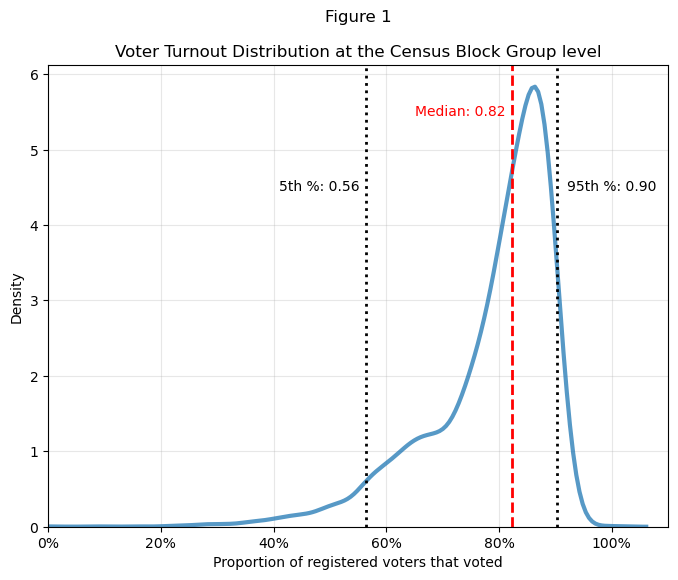

In [25]:
fig,ax = plt.subplots(figsize = (8,6))
sns.kdeplot(final_gdf, x='g20201103_pct_voted_all', linewidth=3,alpha=0.75)
plt.axvline(x=final_gdf['g20201103_pct_voted_all'].median(), linestyle='--', color='r', linewidth=2, label='Median')
plt.axvline(x=np.percentile(final_gdf['g20201103_pct_voted_all'],5), linestyle=':', color='k', linewidth=2, label='5th percentile')
plt.axvline(x=np.percentile(final_gdf['g20201103_pct_voted_all'],95), linestyle=':', color='k', linewidth=2, label='95th percentile')
plt.text(0.65, 5.45, f'Median: {final_gdf['g20201103_pct_voted_all'].median():.2f}', color='r')
plt.text(0.41, 4.45, f'5th %: {np.percentile(final_gdf['g20201103_pct_voted_all'],5):.2f}', color='k')
plt.text(0.92, 4.45, f'95th %: {np.percentile(final_gdf['g20201103_pct_voted_all'],95):.2f}', color='k')
plt.xlim(0,1.1)
xticks = [0 + 0.2*i for i in range(6)]
plt.xticks(ticks=xticks, labels=[f'{x:,.0%}' for x in xticks])
plt.xlabel('Proportion of registered voters that voted')
plt.ylabel('Density')
plt.grid(alpha=0.3)
plt.title('Figure 1\n\nVoter Turnout Distribution at the Census Block Group level')
plt.show()

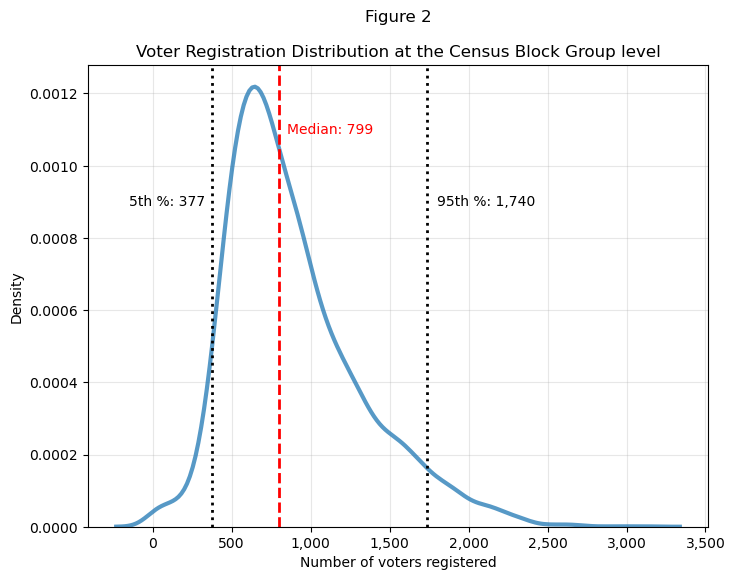

In [26]:
fig,ax = plt.subplots(figsize = (8,6))
sns.kdeplot(final_gdf, x='total_reg', linewidth=3,alpha=0.75)
plt.axvline(x=final_gdf['total_reg'].median(), linestyle='--', color='r', linewidth=2, label='Median')
plt.axvline(x=np.percentile(final_gdf['total_reg'],5), linestyle=':', color='k', linewidth=2, label='5th percentile')
plt.axvline(x=np.percentile(final_gdf['total_reg'],95), linestyle=':', color='k', linewidth=2, label='95th percentile')
plt.text(850, 0.00109, f'Median: {final_gdf['total_reg'].median():,.0f}', color='r')
plt.text(-150, 0.00089, f'5th %: {np.percentile(final_gdf['total_reg'],5):,.0f}', color='k')
plt.text(1800, 0.00089, f'95th %: {np.percentile(final_gdf['total_reg'],95):,.0f}', color='k')
xticks = [0 + 500*i for i in range(8)]
plt.xticks(ticks=xticks, labels=[f'{x:,d}' for x in xticks])
plt.xlabel('Number of voters registered')
plt.ylabel('Density')
plt.grid(alpha=0.3)
plt.title('Figure 2\n\nVoter Registration Distribution at the Census Block Group level')
plt.show()

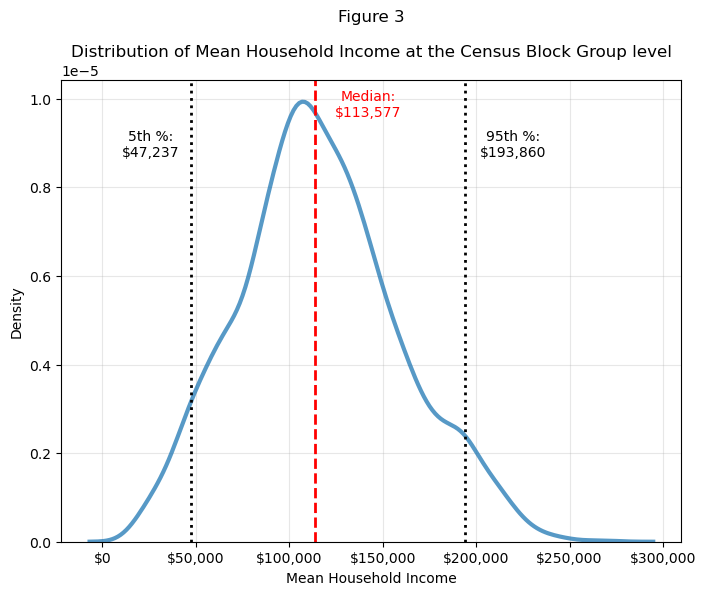

In [27]:
fig,ax = plt.subplots(figsize = (8,6))
sns.kdeplot(final_gdf, x='mean_hh_income', linewidth=3,alpha=0.75)
plt.axvline(x=final_gdf['mean_hh_income'].median(), linestyle='--', color='r', linewidth=2, label='Median')
plt.axvline(x=np.percentile(final_gdf['mean_hh_income'],5), linestyle=':', color='k', linewidth=2, label='5th percentile')
plt.axvline(x=np.percentile(final_gdf['mean_hh_income'],95), linestyle=':', color='k', linewidth=2, label='95th percentile')
plt.text(142000, 0.0000096, f'Median:\n${final_gdf['mean_hh_income'].median():,.0f}', ha='center', color='r')
plt.text(26000, 0.0000087, f'5th %:\n${np.percentile(final_gdf['mean_hh_income'],5):,.0f}', ha='center', color='k')
plt.text(220000, 0.0000087, f'95th %:\n${np.percentile(final_gdf['mean_hh_income'],95):,.0f}', ha='center', color='k')
xticks = [0 + 50000*i for i in range(7)]
plt.xticks(ticks=xticks, labels=[f'${x:,d}' for x in xticks])
plt.xlabel('Mean Household Income')
plt.ylabel('Density')
plt.grid(alpha=0.3)
plt.title('Figure 3\n\nDistribution of Mean Household Income at the Census Block Group level')
plt.show()

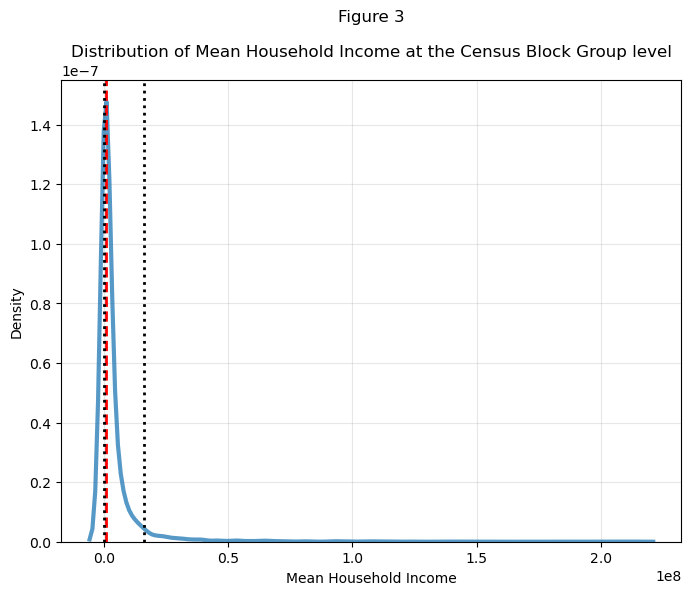

In [28]:
fig,ax = plt.subplots(figsize = (8,6))
sns.kdeplot(final_gdf, x='ALAND20', linewidth=3,alpha=0.75)
plt.axvline(x=final_gdf['ALAND20'].median(), linestyle='--', color='r', linewidth=2, label='Median')
plt.axvline(x=np.percentile(final_gdf['ALAND20'],5), linestyle=':', color='k', linewidth=2, label='5th percentile')
plt.axvline(x=np.percentile(final_gdf['ALAND20'],95), linestyle=':', color='k', linewidth=2, label='95th percentile')
# plt.text(142000, 0.0000096, f'Median:\n${final_gdf['mean_hh_income'].median():,.0f}', ha='center', color='r')
# plt.text(26000, 0.0000087, f'5th %:\n${np.percentile(final_gdf['mean_hh_income'],5):,.0f}', ha='center', color='k')
# plt.text(220000, 0.0000087, f'95th %:\n${np.percentile(final_gdf['mean_hh_income'],95):,.0f}', ha='center', color='k')
# xticks = [0 + 50000*i for i in range(7)]
# plt.xticks(ticks=xticks, labels=[f'${x:,d}' for x in xticks])
plt.xlabel('Mean Household Income')
plt.ylabel('Density')
plt.grid(alpha=0.3)
plt.title('Figure 3\n\nDistribution of Mean Household Income at the Census Block Group level')
plt.show()

Text(0.5, 1.0, 'Figure 4\n\nCorrelation matrix of features')

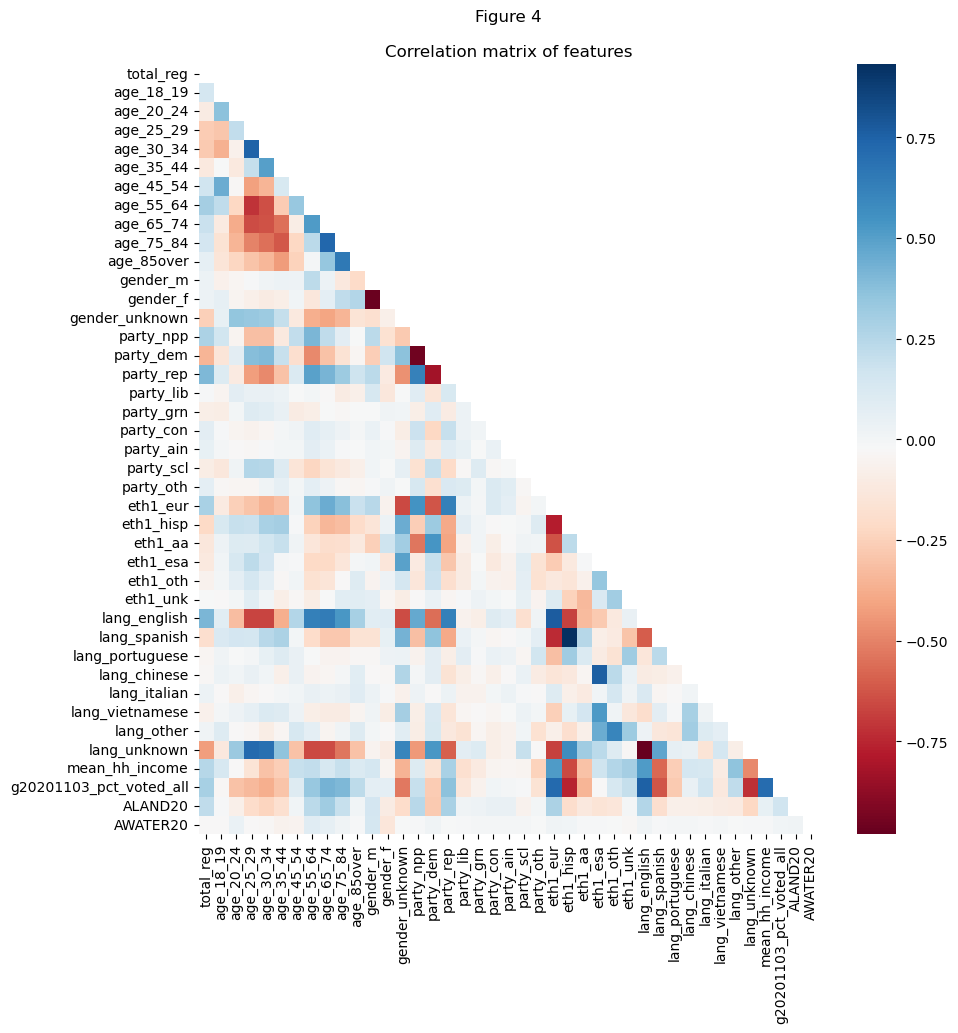

In [29]:
fig,ax = plt.subplots(figsize = (10,10))
corr = final_gdf.drop(['geometry', 'g20201103_voted_all','g20201103_reg_all','tract_id', 'county_id'], axis=1).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='RdBu')
plt.title('Figure 4\n\nCorrelation matrix of features')

### Scatterplots for Correlation Analysis

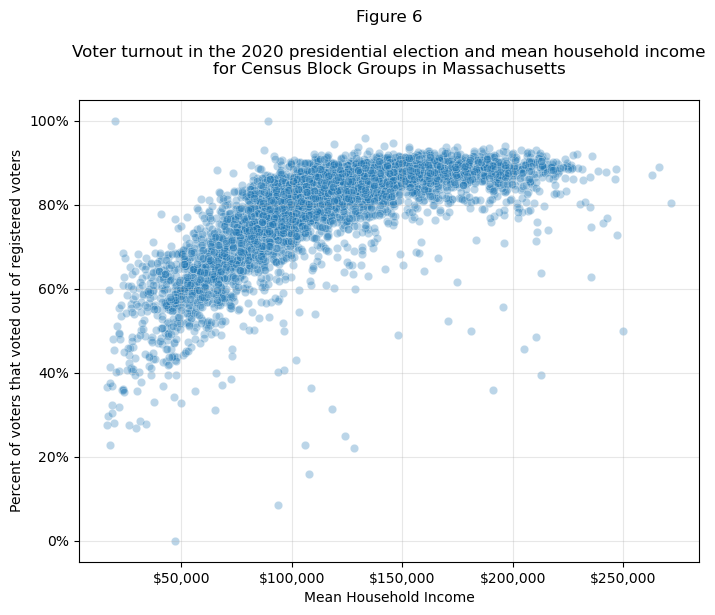

In [30]:
fig,ax = plt.subplots(figsize = (8,6))
sns.scatterplot(final_gdf, x='mean_hh_income', y='g20201103_pct_voted_all', alpha=0.3)
plt.xlabel('Mean Household Income')
plt.ylabel('Percent of voters that voted out of registered voters')
xticks = [50000 + 50000 * i for i in range(5)]
yticks = [0 + 0.2 * i for i in range(6)]
plt.xticks(ticks=xticks, labels=[f'${x:,d}' for x in xticks])
plt.yticks(ticks=yticks, labels=[f'{y:.0%}' for y in yticks])
plt.grid(alpha=0.3)
plt.title('Figure 6\n\nVoter turnout in the 2020 presidential election and mean household income\nfor Census Block Groups in Massachusetts\n ')
plt.show()

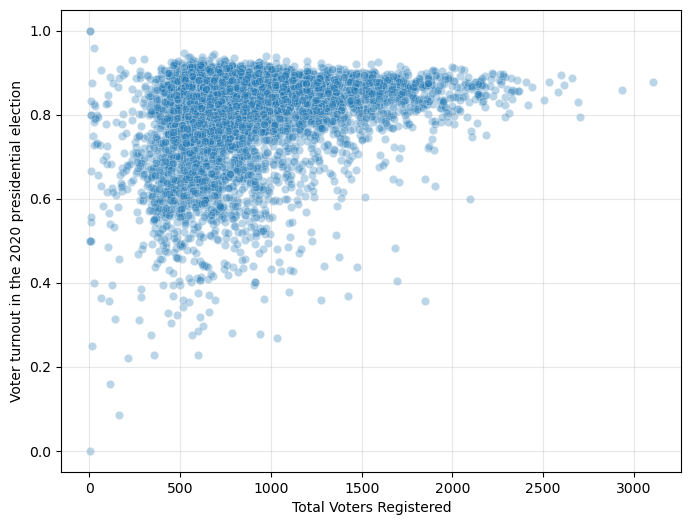

In [31]:
fig,ax = plt.subplots(figsize = (8,6))
sns.scatterplot(final_gdf, x='total_reg', y='g20201103_pct_voted_all', alpha=0.3)
plt.xlabel('Total Voters Registered')
plt.ylabel('Voter turnout in the 2020 presidential election')
plt.grid(alpha=0.3)
plt.show()

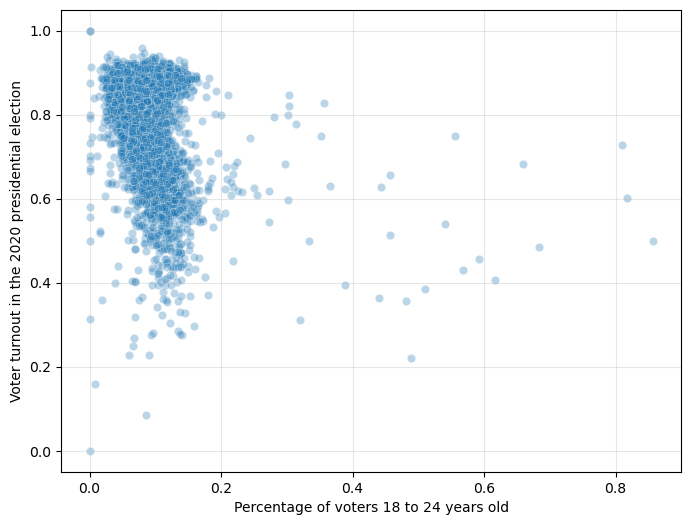

In [32]:
fig,ax = plt.subplots(figsize = (8,6))
sns.scatterplot(x=final_gdf['age_18_19'] + final_gdf['age_20_24'], y=final_gdf['g20201103_pct_voted_all'], alpha=0.3)
plt.xlabel('Percentage of voters 18 to 24 years old')
plt.ylabel('Voter turnout in the 2020 presidential election')
plt.grid(alpha=0.3)
plt.show()

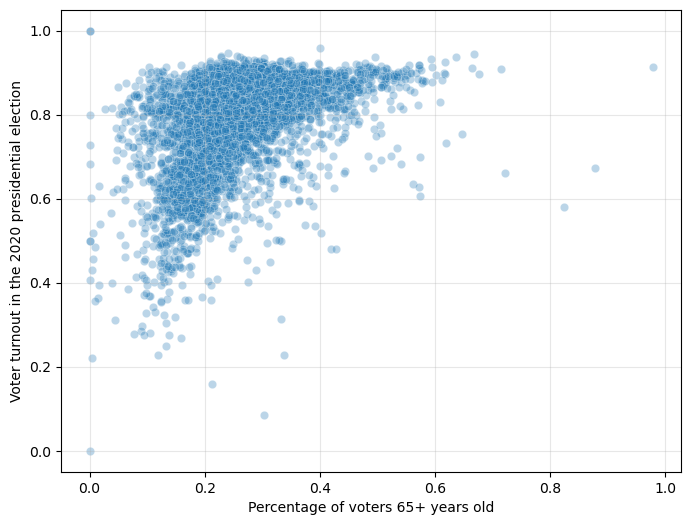

In [33]:
fig,ax = plt.subplots(figsize = (8,6))
sns.scatterplot(x=final_gdf['age_65_74'] + final_gdf['age_75_84'] + final_gdf['age_85over'], y=final_gdf['g20201103_pct_voted_all'], alpha=0.3)
plt.xlabel('Percentage of voters 65+ years old')
plt.ylabel('Voter turnout in the 2020 presidential election')
plt.grid(alpha=0.3)
plt.show()

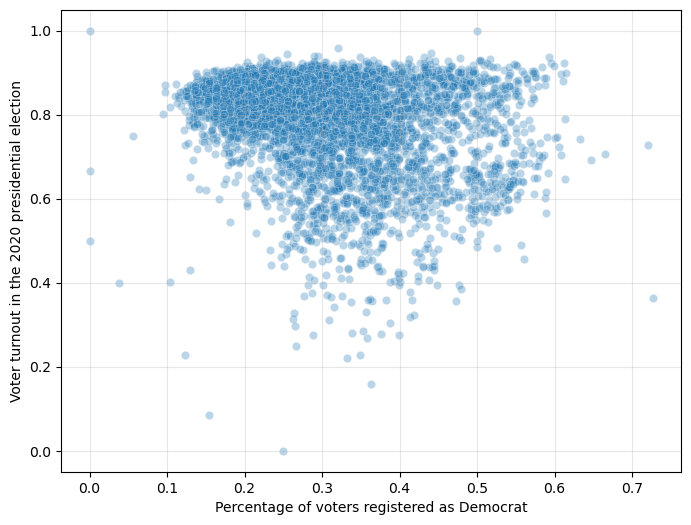

In [34]:
fig,ax = plt.subplots(figsize = (8,6))
sns.scatterplot(final_gdf, x='party_dem', y='g20201103_pct_voted_all', alpha=0.3)
plt.xlabel('Percentage of voters registered as Democrat')
plt.ylabel('Voter turnout in the 2020 presidential election')
plt.grid(alpha=0.3)
plt.show()

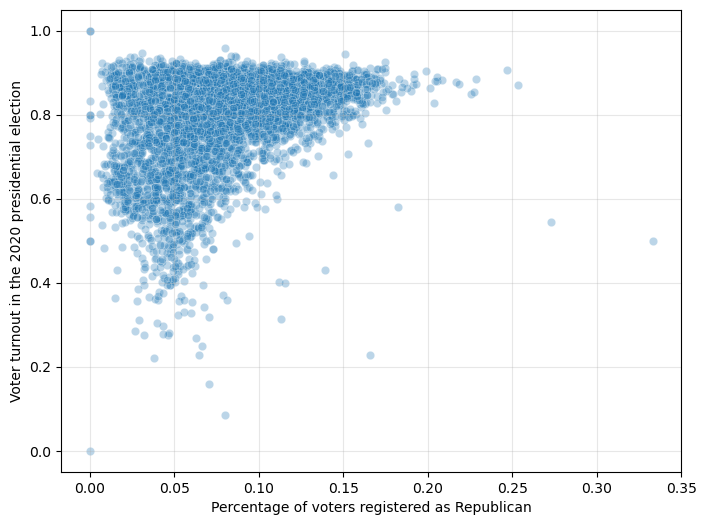

In [35]:
fig,ax = plt.subplots(figsize = (8,6))
sns.scatterplot(final_gdf, x='party_rep', y='g20201103_pct_voted_all', alpha=0.3)
plt.xlabel('Percentage of voters registered as Republican')
plt.ylabel('Voter turnout in the 2020 presidential election')
plt.grid(alpha=0.3)
plt.show()

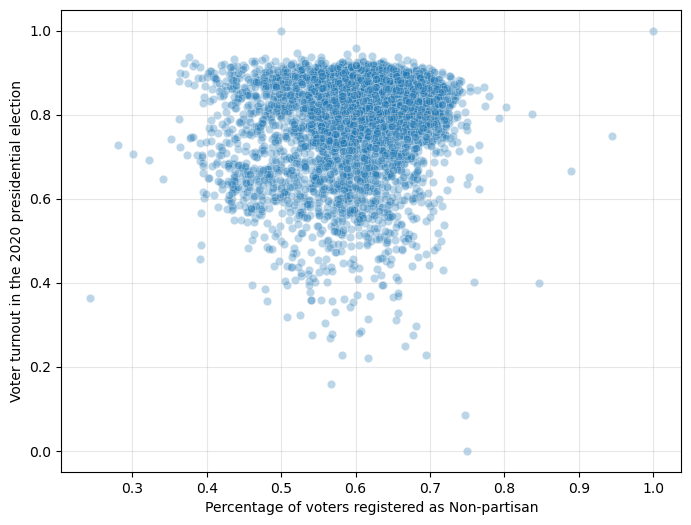

In [36]:
fig,ax = plt.subplots(figsize = (8,6))
sns.scatterplot(final_gdf, x='party_npp', y='g20201103_pct_voted_all', alpha=0.3)
plt.xlabel('Percentage of voters registered as Non-partisan')
plt.ylabel('Voter turnout in the 2020 presidential election')
plt.grid(alpha=0.3)
plt.show()

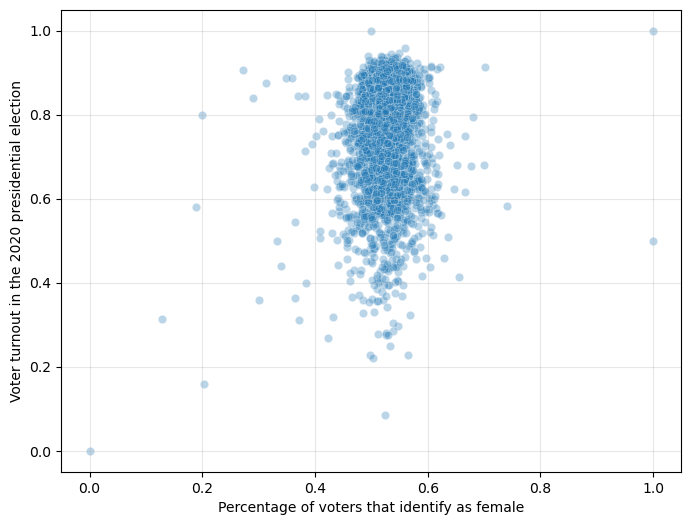

In [37]:
fig,ax = plt.subplots(figsize = (8,6))
sns.scatterplot(final_gdf, x='gender_f', y='g20201103_pct_voted_all', alpha=0.3)
plt.xlabel('Percentage of voters that identify as female')
plt.ylabel('Voter turnout in the 2020 presidential election')
plt.grid(alpha=0.3)
plt.show()

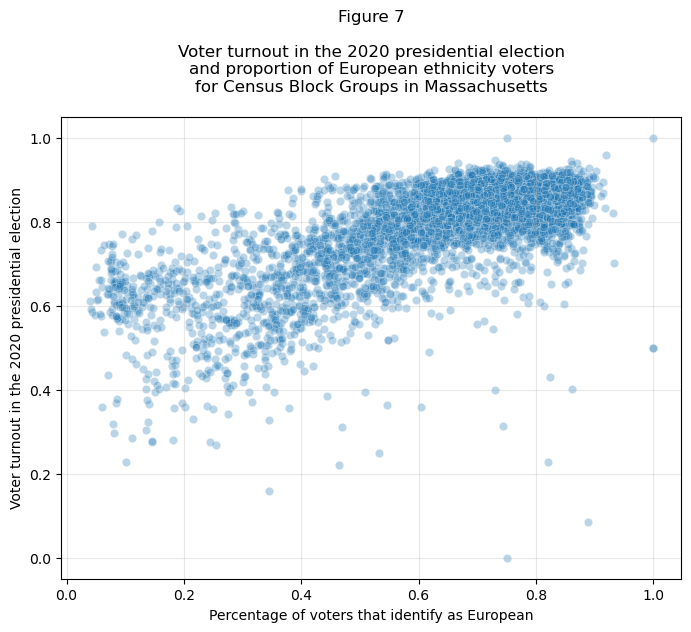

In [51]:
fig,ax = plt.subplots(figsize = (8,6))
sns.scatterplot(final_gdf, x='eth1_eur', y='g20201103_pct_voted_all', alpha=0.3)
plt.xlabel('Percentage of voters that identify as European')
plt.ylabel('Voter turnout in the 2020 presidential election')
plt.grid(alpha=0.3)
plt.title('Figure 7\n\nVoter turnout in the 2020 presidential election\nand proportion of European ethnicity voters\nfor Census Block Groups in Massachusetts\n ')
plt.show()

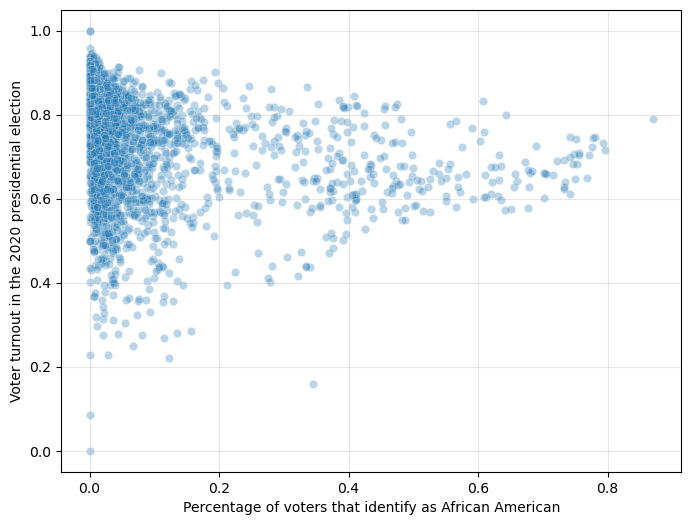

In [39]:
fig,ax = plt.subplots(figsize = (8,6))
sns.scatterplot(final_gdf, x='eth1_aa', y='g20201103_pct_voted_all', alpha=0.3)
plt.xlabel('Percentage of voters that identify as African American')
plt.ylabel('Voter turnout in the 2020 presidential election')
plt.grid(alpha=0.3)
plt.show()

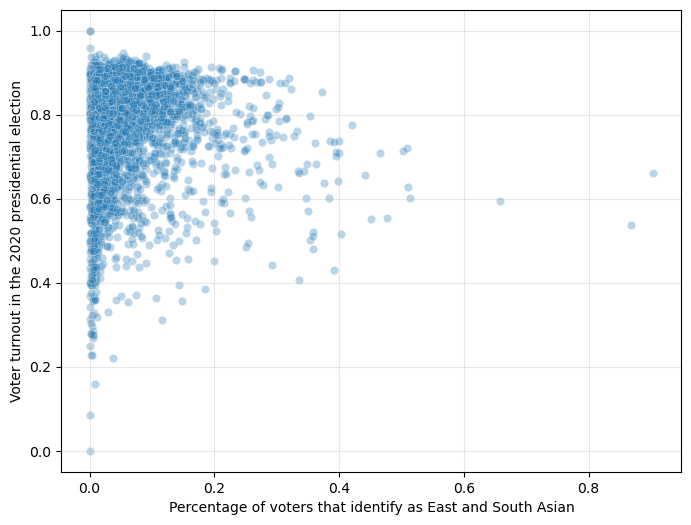

In [40]:
fig,ax = plt.subplots(figsize = (8,6))
sns.scatterplot(final_gdf, x='eth1_esa', y='g20201103_pct_voted_all', alpha=0.3)
plt.xlabel('Percentage of voters that identify as East and South Asian')
plt.ylabel('Voter turnout in the 2020 presidential election')
plt.grid(alpha=0.3)
plt.show()

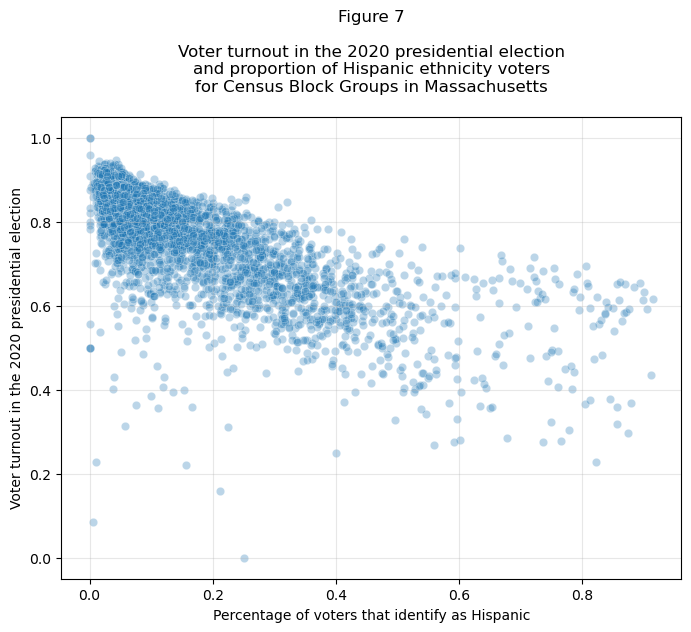

In [52]:
fig,ax = plt.subplots(figsize = (8,6))
sns.scatterplot(final_gdf, x='eth1_hisp', y='g20201103_pct_voted_all', alpha=0.3)
plt.xlabel('Percentage of voters that identify as Hispanic')
plt.ylabel('Voter turnout in the 2020 presidential election')
plt.grid(alpha=0.3)
plt.title('Figure 7\n\nVoter turnout in the 2020 presidential election\nand proportion of Hispanic ethnicity voters\nfor Census Block Groups in Massachusetts\n ')
plt.show()

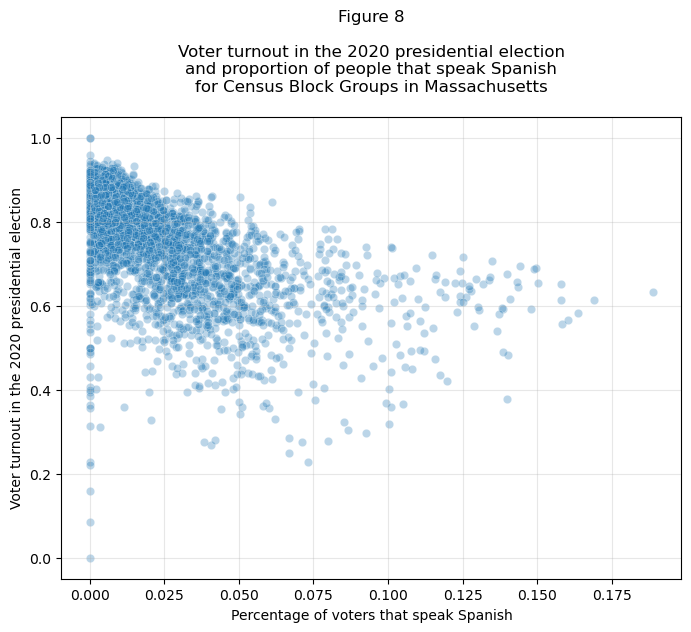

In [54]:
fig,ax = plt.subplots(figsize = (8,6))
sns.scatterplot(final_gdf, x='lang_spanish', y='g20201103_pct_voted_all', alpha=0.3)
plt.xlabel('Percentage of voters that speak Spanish')
plt.ylabel('Voter turnout in the 2020 presidential election')
plt.grid(alpha=0.3)
plt.title('Figure 8\n\nVoter turnout in the 2020 presidential election\nand proportion of people that speak Spanish\nfor Census Block Groups in Massachusetts\n ')
plt.show()

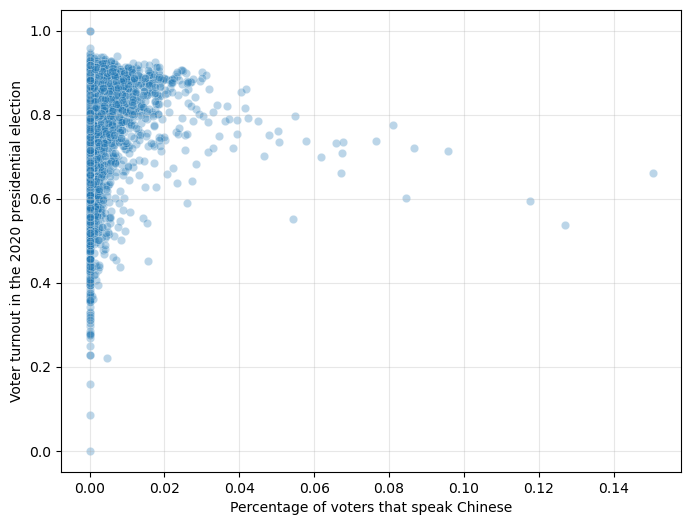

In [43]:
fig,ax = plt.subplots(figsize = (8,6))
sns.scatterplot(final_gdf, x='lang_chinese', y='g20201103_pct_voted_all', alpha=0.3)
plt.xlabel('Percentage of voters that speak Chinese')
plt.ylabel('Voter turnout in the 2020 presidential election')
plt.grid(alpha=0.3)
plt.show()

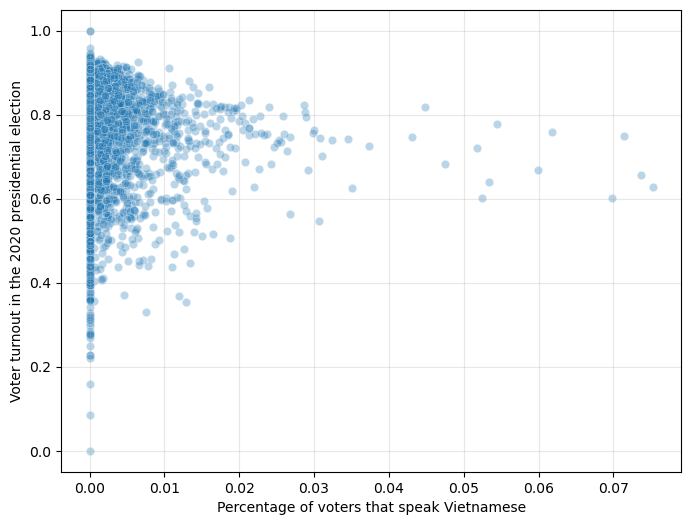

In [44]:
fig,ax = plt.subplots(figsize = (8,6))
sns.scatterplot(final_gdf, x='lang_vietnamese', y='g20201103_pct_voted_all', alpha=0.3)
plt.xlabel('Percentage of voters that speak Vietnamese')
plt.ylabel('Voter turnout in the 2020 presidential election')
plt.grid(alpha=0.3)
plt.show()

### Map Visualizations

In [81]:
# Define tract and county GeoDataFrame
wm_bg = lambda x: (
    np.average(x.dropna(), weights=final_gdf.loc[x.dropna().index, 'total_reg'])
    if final_gdf.loc[x.dropna().index, 'total_reg'].sum() > 0
    else np.nan
)

agg_funcs = {col: 'sum' for col in final_gdf.columns if col not in ['mean_hh_income','g20201103_pct_voted_all','geometry']}
agg_funcs.update({'mean_hh_income': wm_bg})
tract_gdf = final_gdf.dissolve(by='tract_id', aggfunc=agg_funcs)
tract_gdf['g20201103_pct_voted_all'] = tract_gdf['g20201103_voted_all'] / tract_gdf['g20201103_reg_all']
county_gdf = final_gdf.dissolve(by='county_id', aggfunc=agg_funcs)
county_gdf['g20201103_pct_voted_all'] = county_gdf['g20201103_voted_all'] / county_gdf['g20201103_reg_all']

Text(0.5, 1.0, 'Figure 9\n\n% of voters absent in the 2020 presidential election (MA Census Tracts)')

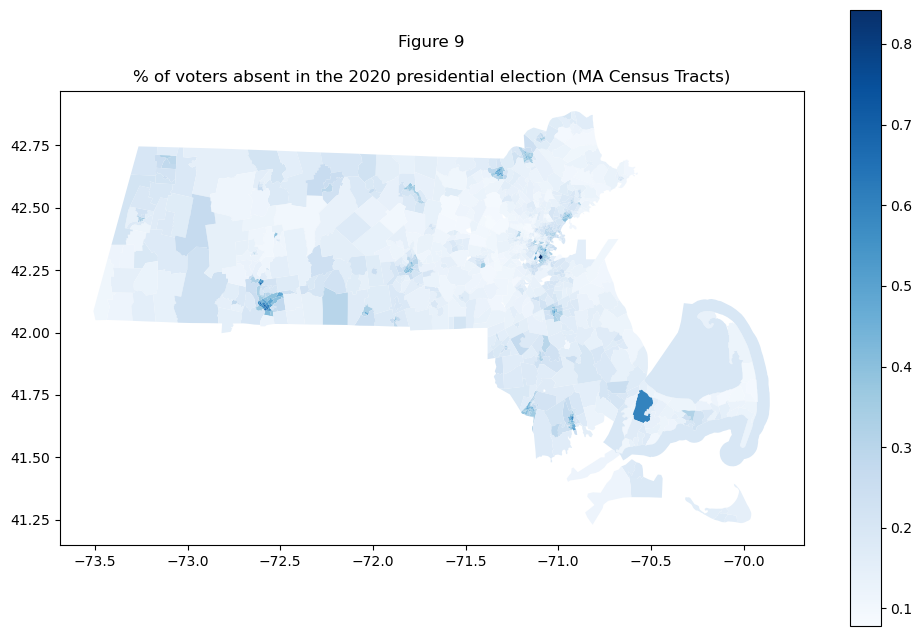

In [82]:
fig,ax = plt.subplots(figsize=(12,8))
tract_gdf['g20201103_pct_absent_all'] = 1 - tract_gdf['g20201103_pct_voted_all']
tract_gdf.plot(column='g20201103_pct_absent_all', cmap='Blues', legend=True,ax=ax)
plt.title('Figure 9\n\n% of voters absent in the 2020 presidential election (MA Census Tracts)')

Text(0.5, 1.0, 'Figure 10\n\n% of voters absent in the 2020 presidential election (MA Counties)')

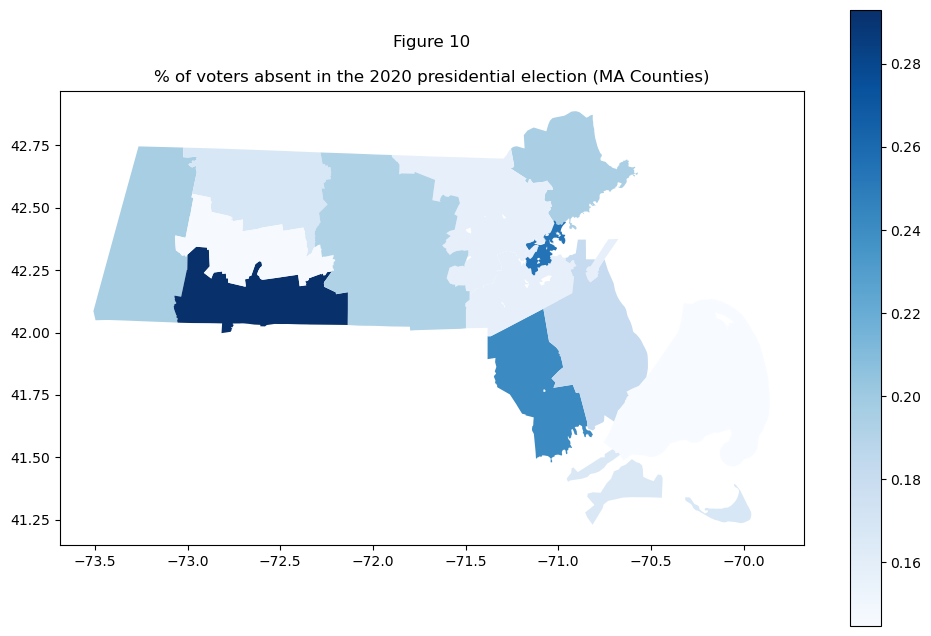

In [83]:
fig,ax = plt.subplots(figsize=(12,8))
county_gdf['g20201103_pct_absent_all'] = 1 - county_gdf['g20201103_pct_voted_all']
county_gdf.plot(column='g20201103_pct_absent_all', cmap='Blues', legend=True,ax=ax)
plt.title('Figure 10\n\n% of voters absent in the 2020 presidential election (MA Counties)')

Text(0.5, 1.0, 'Figure 11\n\nNumber of voters registered (MA Census Tracts)')

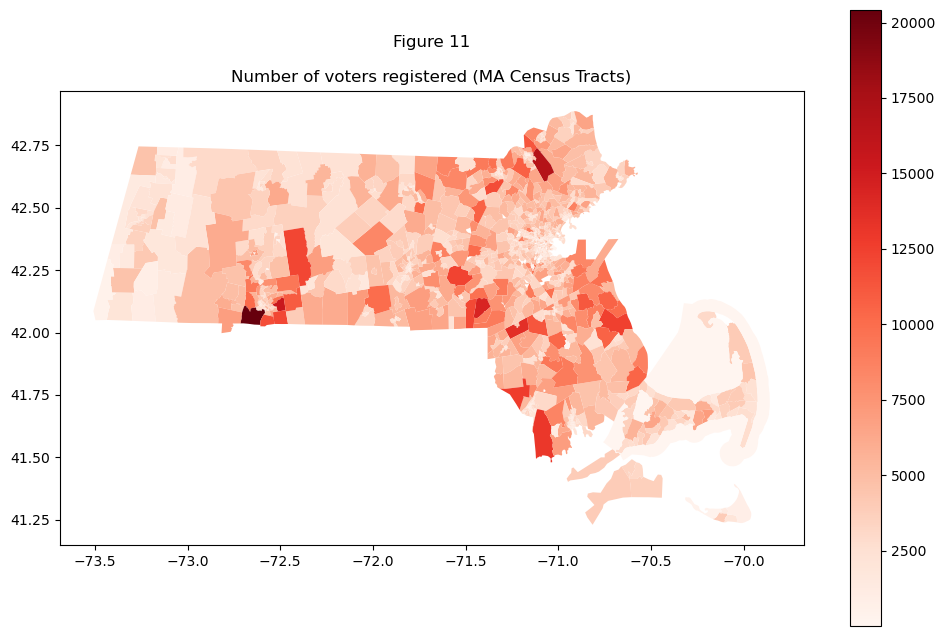

In [84]:
fig,ax = plt.subplots(figsize=(12,8))
tract_gdf.plot(column='total_reg', cmap='Reds', legend=True,ax=ax)
plt.title('Figure 11\n\nNumber of voters registered (MA Census Tracts)')

Text(0.5, 1.0, 'Figure 12\n\nNumber of voters registered (MA Counties)')

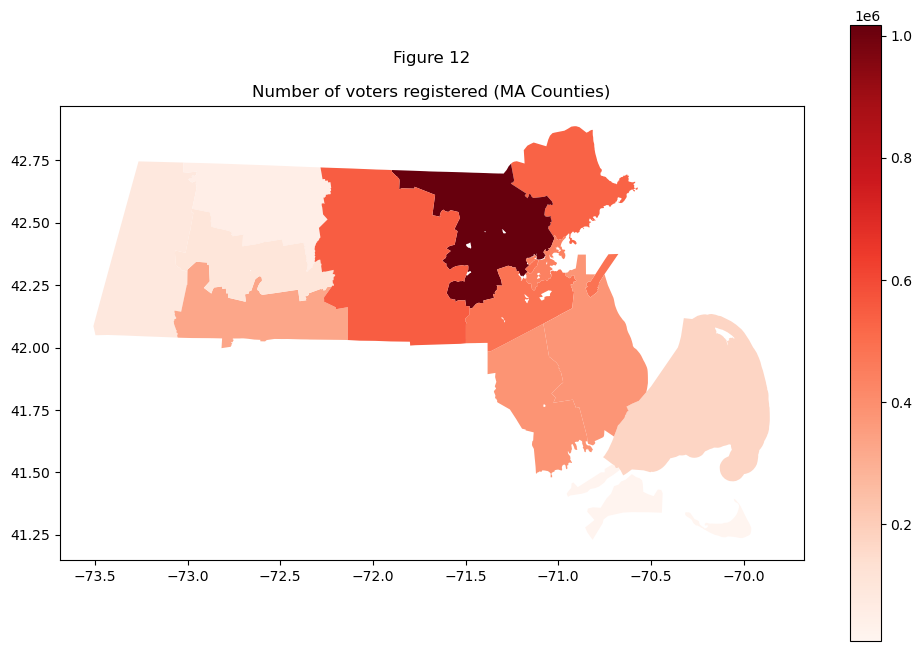

In [85]:
fig,ax = plt.subplots(figsize=(12,8))
county_gdf.plot(column='total_reg', cmap='Reds', legend=True, ax=ax)
plt.title('Figure 12\n\nNumber of voters registered (MA Counties)')

Text(0.5, 1.0, 'Figure 13\n\nMean HH Income (MA Census Tracts)')

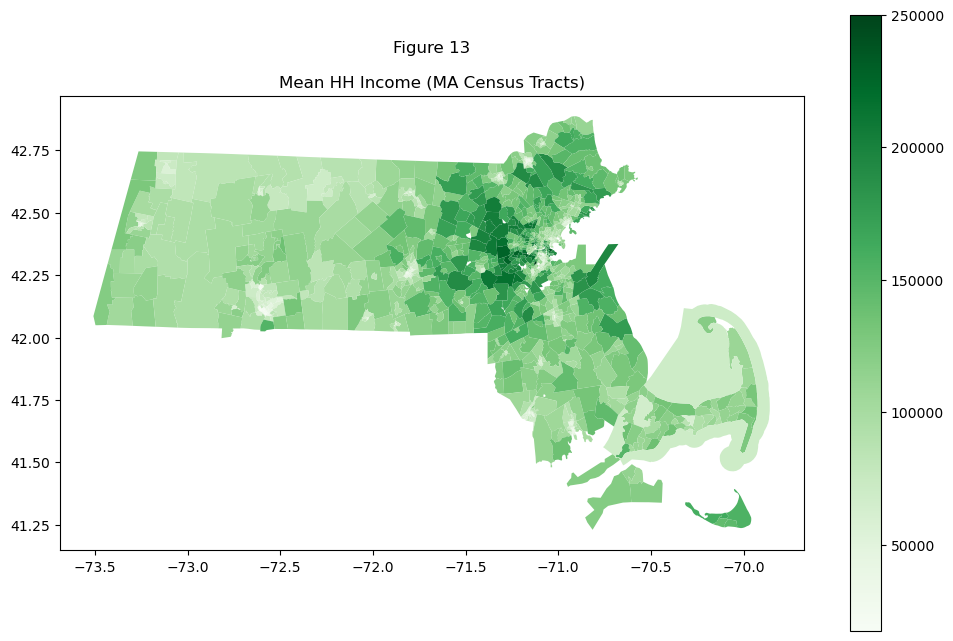

In [86]:
fig,ax = plt.subplots(figsize=(12,8))
tract_gdf.plot(column='mean_hh_income', cmap='Greens', legend=True,ax=ax)
plt.title('Figure 13\n\nMean HH Income (MA Census Tracts)')

Text(0.5, 1.0, 'Figure 14\n\nMean HH Income (MA Counties)')

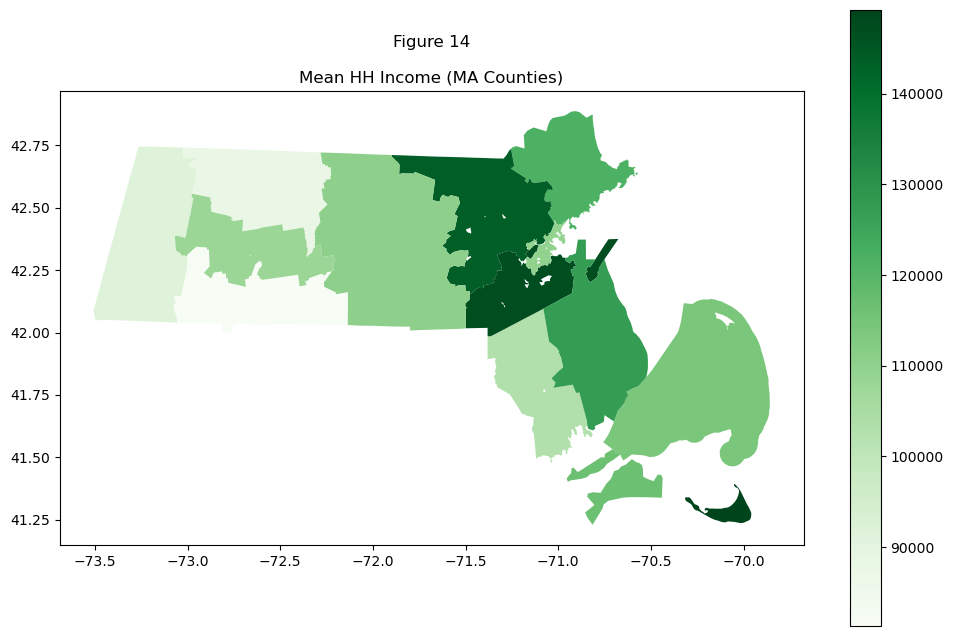

In [87]:
fig,ax = plt.subplots(figsize=(12,8))
county_gdf.plot(column='mean_hh_income', cmap='Greens', legend=True,ax=ax)
plt.title('Figure 14\n\nMean HH Income (MA Counties)')

## Baseline Model

### Train test split

Make sure to stratify with total voter registration by Census Block Groups.